In [1]:
import numpy as np
import scipy.linalg as la
import fun as f
import networkx as nx
from scipy.integrate import quad
from matplotlib import pyplot as plt
from collections import Counter

## Test cases:
* Verify the integral is computed correctly by comparing with the quad function form `scipy`
* Compute the sgd between the same graph, result must be zero.
* Evaluate the experiments performed with the WS models with reference models generated for different rewiring probabilities.

## Verify all WS models are composed by a single component:

In [2]:
readWSmodels = nx.read_gpickle("081120_WS_models.json")

In [3]:
is_all_connected_p0 = []
for p in readWSmodels['G_p0'].keys():
    is_all_connected_p0.append(nx.is_connected(readWSmodels['G_p0'][p]))
counter_p0 = Counter(is_all_connected_p0)

In [4]:
is_all_connected_p = {}
for p, graph in readWSmodels['G_p'].items():
    temp = []
    for rep in graph.keys():
        temp.append(nx.is_connected(readWSmodels['G_p'][p][rep]))
    is_all_connected_p[p] = Counter(temp)     

## Verify my integrate function: trivial case

In [5]:
W_1 = np.ones((5,5))
D_1 = np.diag(np.sum(W_1,0))
L_1 = D_1 - W_1

In [6]:
eigenvalues_L1, eigenvectors_L1 = la.eig(L_1)
eigenvalues_L1 = eigenvalues_L1.real

In [7]:
W_2 = W_1 + 1
D_2 = np.diag(np.sum(W_2, 0))
L_2 = D_2 - W_2

In [8]:
eigenvalues_L2, eigenvectors_L2 = la.eig(L_2)
eigenvalues_L2 = eigenvalues_L2.real

In [9]:
norm_eigenv1 = np.copy(eigenvectors_L1)
for i in range(len(eigenvectors_L1)):
    dem = (np.max(eigenvectors_L1[:,i]) - np.min(eigenvectors_L1[:,i]))
    num = (eigenvectors_L1[:,i] - np.min(eigenvectors_L1[:,i] ))
    norm_eigenv1[:,i] = num/dem


In [10]:
norm_eigenv2 = np.copy(eigenvectors_L2)
for i in range(len(eigenvectors_L2)):
    dem = (np.max(eigenvectors_L2[:,i]) - np.min(eigenvectors_L2[:,i]))
    num = (eigenvectors_L2[:,i] - np.min(eigenvectors_L2[:,i] ))
    norm_eigenv2[:,i] = num/dem


In [11]:
f.pairwise_spectral_dist(f.sort_eigenv(eigenvalues_L1, eigenvectors_L1),
                         f.sort_eigenv(eigenvalues_L2, eigenvectors_L2))

(0.0, 1.457167719820518e-17)

## Verify my integrate function

In [ ]:
#Sanity check: Check if my CDF matches with the integrate function in python:
G1=r_eigenv_p0
Ni = len(r_eigenv_p0)
Nj = len(ws_graphs_z[0.02][2])
Mij = min(Ni, Nj)
integral = []
area = []
signs =[-1,1]

for r in range(1, Mij):
    temp_integral=[]
    temp_area = []
    for  sign_s in signs:
        for sign_l in signs:
            vri = sorted(g.normalize_eigenv(sign_s * G1[r][1]))
            vrj = sorted(g.normalize_eigenv(sign_l * ws_graphs_z[0.02][2][r][1]))
            u = sorted(list(set(vri + vrj)))
            cdf_distance = 0
            vri_count = 0
            vrj_count = 0
            res = quad(integrand_kd, 0., 1., epsabs = 1e-4, limit = 2000,
                       args=(Ni, Nj, np.array(vri), np.array(vrj)))[0]
            temp_integral.append(res)
    
            for idx, sorted_elt in enumerate(u[1:]):
                # adding rectangle area, L * W
                cdf_distance += (u[idx] - u[idx - 1]) * abs((vri_count)/Ni - (vrj_count)/Nj)
                if sorted_elt in vri:
                    vri_count += 1
                if sorted_elt in vrj:
                    vrj_count += 1
            temp_area.append(cdf_distance)
    #print(f'{min(temp_area)}, {min(cdf_distance_list)}')        
    area.append(min(temp_area))   
    integral.append(min(temp_integral))
    
    #print(f' {r}, integral: {temp_integral}')
    #print(f'{r}, area: {temp_area}')
    
print(f'integral: {sum(integral)/(len(r_eigenv_p02)-1)}, area:{sum(area)/(len(r_eigenv_p02)-1)}')    

## Test Hamming Distance

In [12]:
#Generate models to compare:
test_hd = {}
n=10
k=4
rp = np.arange(0,1.1,0.1)
for p in rp:
    test_hd[p] = nx.watts_strogatz_graph(n, k, p,1234)

In [13]:
#Compute Hamming Distance:
matrix_test = np.zeros((len(rp), len(rp)))
for idxi, i  in enumerate(rp):
    for idxj, j in enumerate(rp):
        matrix_test[idxi][idxj] = np.round(np.sum(np.abs(nx.adjacency_matrix(test_hd[i]).todense()
                                                         - nx.adjacency_matrix(test_hd[j]).todense()))/(10 * 9),2
                                          )
        

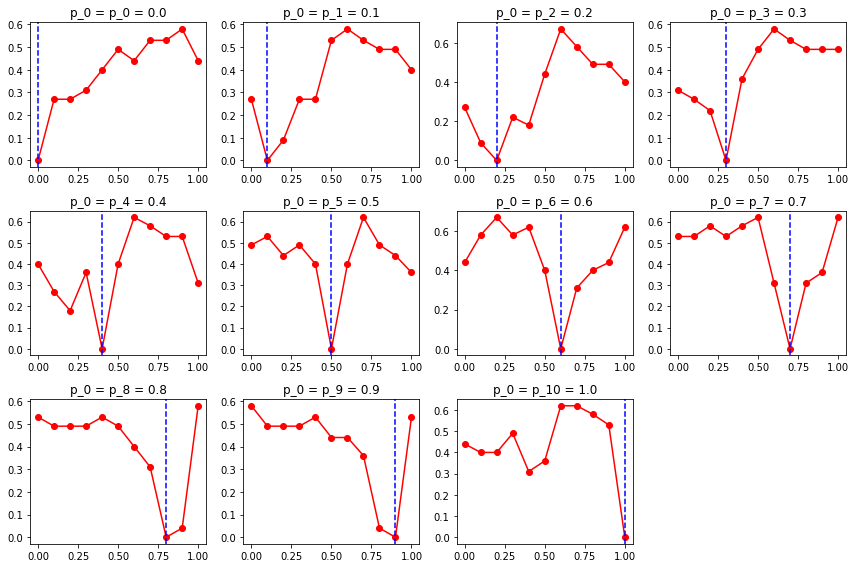

In [14]:
fig = plt.figure(figsize=(12, 8))
for i in range(len(rp)):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.title('p_0 = p_'+str(i) + " = " + str(np.round(rp[i],3)) )
    plt.plot(rp, matrix_test[i], '-o', color = 'red')
    plt.axvline(x = rp[i], color = 'blue', linestyle = '--')
    

In [15]:
## Generate Reference models
test_reference_hd = {}
n=10
k=4
rp = np.arange(0,1.1,0.1)
for p in rp:
    test_reference_hd[p] = nx.watts_strogatz_graph(n, k, p, seed=152345)

In [16]:
#Compute Hamming Distance:
matrix_test = np.zeros((len(rp), len(rp)))
for idxi, i  in enumerate(rp):
    for idxj, j in enumerate(rp):
        matrix_test[idxi][idxj] = np.sum(np.abs(nx.adjacency_matrix(test_reference_hd[i]).todense()
                                                         - nx.adjacency_matrix(test_hd[j]).todense()))/(n*(n-1))
        

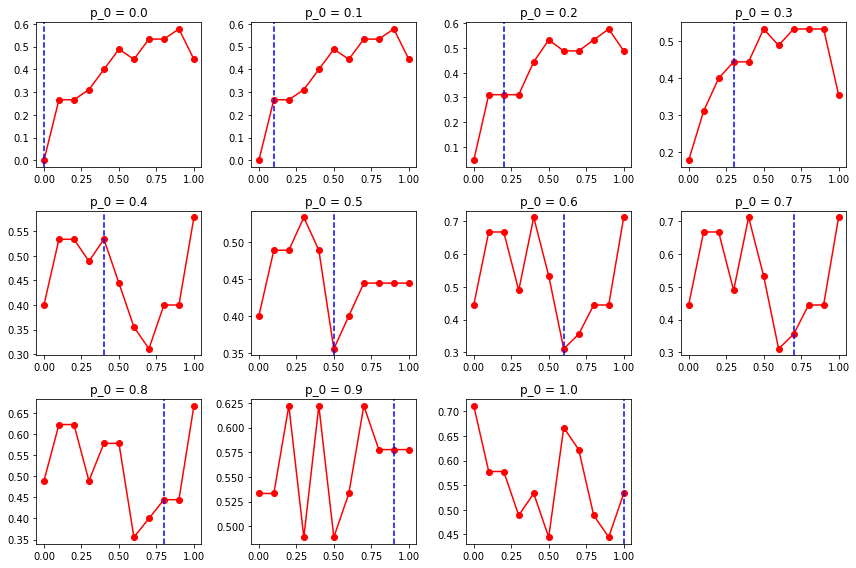

In [17]:
fig = plt.figure(figsize=(12, 8))
for i in range(len(rp)):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.title('p_0 = '+ str(np.round(rp[i],3)) )
    plt.plot(rp, matrix_test[i], '-o', color = 'red')
    plt.axvline(x = rp[i], color = 'blue', linestyle = '--')
    

## Bigger networks

In [18]:
## For bigger networks:
test_hd = {}
n=300
k=10
rp = np.arange(0,1.1,0.1)
for p in rp:
    test_hd[p] = nx.watts_strogatz_graph(n, k, p)

In [19]:
#Compute Hamming Distance:
matrix_test = np.zeros((len(rp), len(rp)))
for idxi, i  in enumerate(rp):
    for idxj, j in enumerate(rp):
        matrix_test[idxi][idxj] = np.round(np.sum(np.abs(nx.adjacency_matrix(test_hd[i]).todense()
                                                         - nx.adjacency_matrix(test_hd[j]).todense()))/(10 * 9),2
                                          )
        

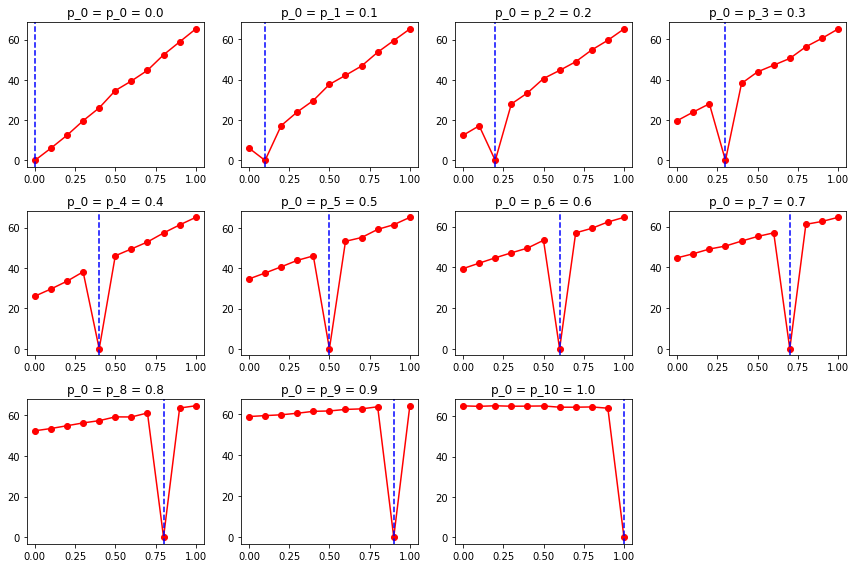

In [20]:
fig = plt.figure(figsize=(12, 8))
for i in range(len(rp)):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.title('p_0 = p_'+ str(i) + " = " + str(np.round(rp[i],3)) )
    plt.plot(rp, matrix_test[i], '-o', color = 'red')
    plt.axvline(x = rp[i], color = 'blue', linestyle = '--')
    

# With reference model:

In [21]:
## Generate Reference models
test_reference_hd = {}
n=300
k=10
rp = np.arange(0,1.1,0.1)
for p in rp:
    test_reference_hd[p] = nx.watts_strogatz_graph(n, k, p, seed=152345)

In [22]:
#Compute Hamming Distance:
matrix_test = np.zeros((len(rp), len(rp)))
ref_dist = {}
for idxi, i  in enumerate(rp):
    temp = []
    for idxj, j in enumerate(rp):
        temp.append(np.sum(np.abs(nx.adjacency_matrix(test_reference_hd[i]).todense() - nx.adjacency_matrix(test_hd[j]).todense()))/(n*(n-1)) )
    ref_dist[i] = temp
    

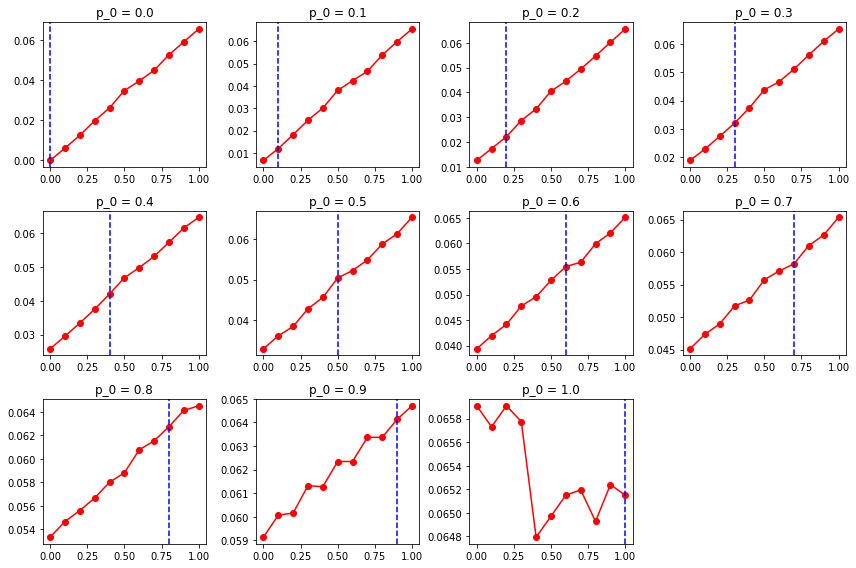

In [23]:
fig = plt.figure(figsize=(12, 8))
for i in range(len(rp)):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.title('p_0 = '+ str(np.round(rp[i],3)) )
    plt.plot(rp, ref_dist[rp[i]], '-o', color = 'red')
    plt.axvline(x = rp[i], color = 'blue', linestyle = '--')
    